--- Initializing Data and Models ---
[INFO] Data loaded and preprocessed successfully. Numerical features normalized.

--- Running Example Queries ---

Training model for rohu (species_num=104)...
[INFO] Data size for rohu: 63 samples. Using SIMPLIFIED XGBoost model (data < 100 samples). 
[INFO] Data split for rohu: Train=31 samples, Validation=8 samples, Test=10 samples.
[INFO] Final MSE for rohu (species_num=104): 0.0005

--- Visualizing Predictions for Rohu ---


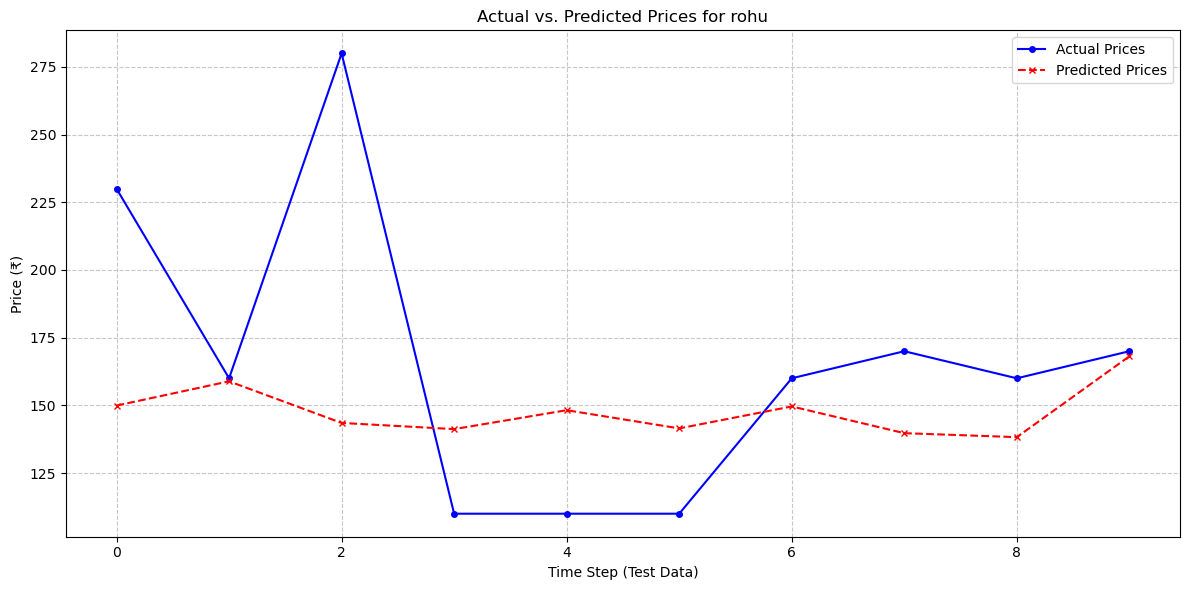

[INFO] Plot for rohu displayed.

--- Predicting next price for Rohu ---
{'species_name': 'rohu', 'predicted_price': 158.72553139925, 'model_used': 'simple_xgb', 'message': 'Predicted next price for rohu (using simple xgb model): ₹158.73'}

--- Comparing Fluctuations for Catla and Tilapia in July ---
{'fish1_name': 'catla', 'fish2_name': 'tilapia', 'month': 7, 'fluctuation1': 200.0, 'fluctuation2': 340.0, 'message': 'Fluctuations in catla during month 7: ₹200.00 | Fluctuations in tilapia during month 7: ₹340.00'}

--- Finding Cheapest Fish in Quarter 1 ---
{'quarter': 1, 'cheapest_species_name': 'gold_spotted_granadier_anchovy', 'cheapest_species_num': 38, 'avg_price': 282.2128333333333, 'message': 'Cheapest fish in Q1: gold_spotted_granadier_anchovy (avg price: ₹282.21)'}

Magur (species_num=75) has 64 data points.

Training model for magur (species_num=75)...
[INFO] Data size for magur: 64 samples. Using SIMPLIFIED XGBoost model (data < 100 samples). 
[INFO] Data split for magur: Trai

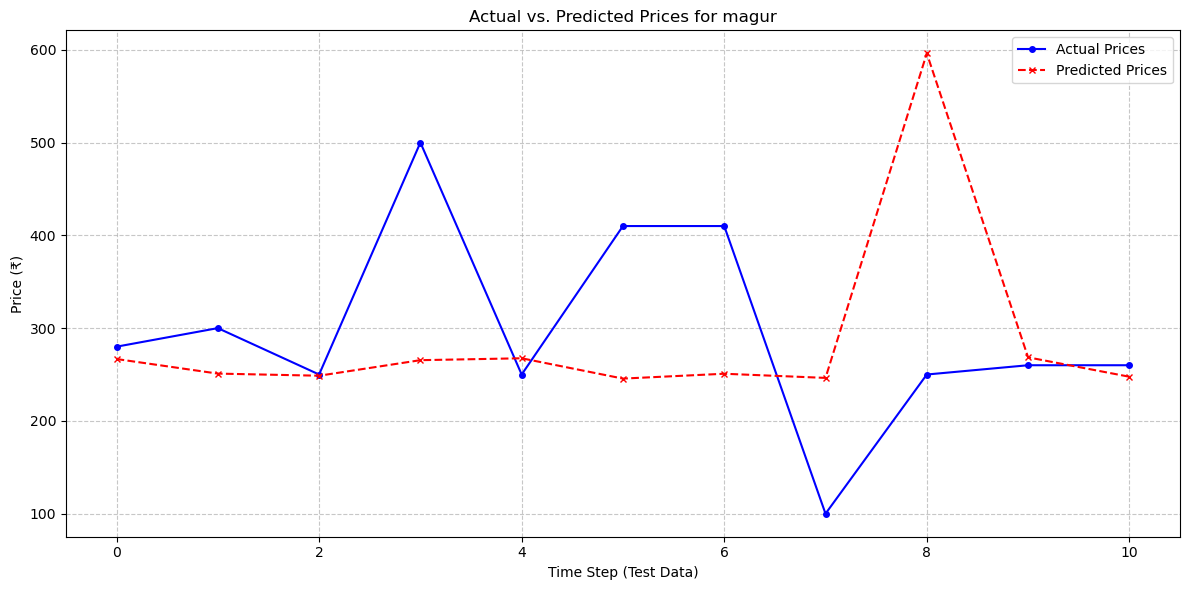

[INFO] Plot for magur displayed.

--- Predicting next price for Magur ---
{'species_name': 'magur', 'predicted_price': 248.12830381095407, 'model_used': 'simple_xgb', 'message': 'Predicted next price for magur (using simple xgb model): ₹248.13'}

Catla (species_num=18) has 63 data points.

Training model for catla (species_num=18)...
[INFO] Data size for catla: 63 samples. Using SIMPLIFIED XGBoost model (data < 100 samples). 
[INFO] Data split for catla: Train=35 samples, Validation=9 samples, Test=12 samples.
[INFO] Final MSE for catla (species_num=18): 0.0010

--- Visualizing Predictions for Catla ---


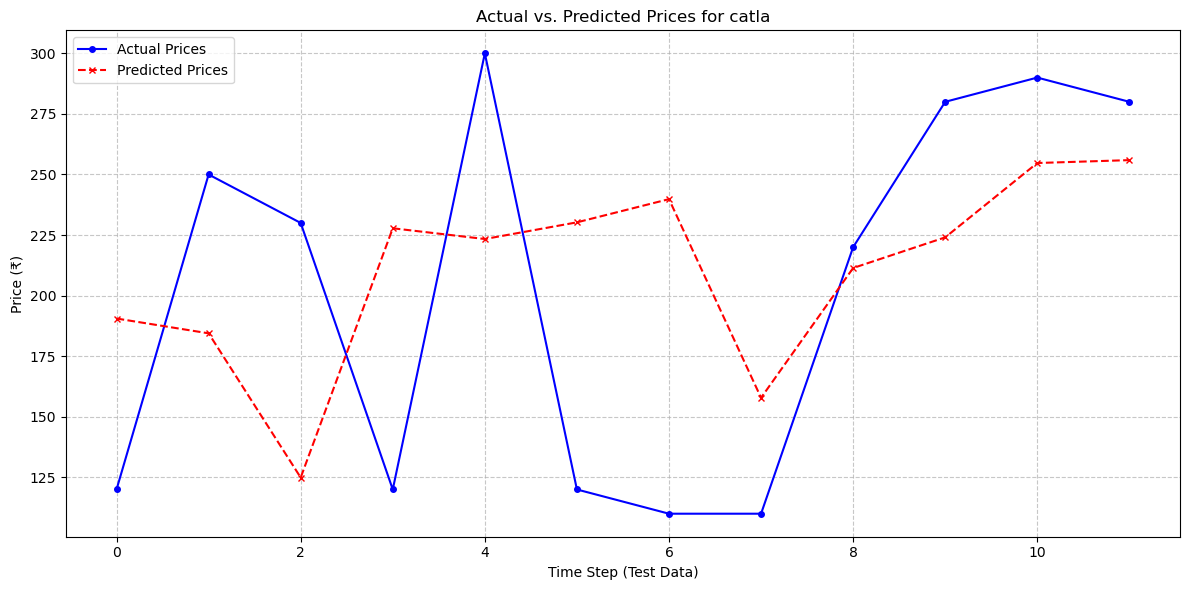

[INFO] Plot for catla displayed.

--- Predicting next price for Catla ---
{'species_name': 'catla', 'predicted_price': 185.61451740562913, 'model_used': 'simple_xgb', 'message': 'Predicted next price for catla (using simple xgb model): ₹185.61'}


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt # Import for visualizations

# --- Global Variables & Model Storage ---
# In a real backend, these would be loaded once when the server starts
# to avoid re-loading/re-training for every request.
# We'll simulate this by initializing them globally.
data_df = None
species_map_global = None
name_to_num_global = None
scaler_global = None
# Stores {species_num: {'lstm_model': ..., 'xgb_model': ..., 'fish_data': ..., 'seq_length': ..., 'model_type': 'stacked' or 'simple_xgb'}}
trained_models = {}

# --- Data Loading and Preprocessing Function ---
def load_and_preprocess_data():
    global data_df, species_map_global, name_to_num_global, scaler_global

    # Load Main Dataset
    try:
        data_df = pd.read_csv("dataset_for_model_2.csv", parse_dates=["date"])
        data_df.sort_values("date", inplace=True)
    except FileNotFoundError:
        print("[ERROR] 'dataset_for_model.csv' not found. Please ensure it's in the correct path.")
        return False

    # Load Species Mapping
    try:
        species_index = pd.read_csv("species_index.csv")
        species_map_global = dict(zip(species_index["species_num"], species_index["species"]))
        name_to_num_global = dict(zip(species_index["species"], species_index["species_num"]))
    except FileNotFoundError:
        print("[ERROR] 'species_index.csv' not found. Please ensure it's in the correct path.")
        return False

    # Define all numerical features that will be scaled and used as input to models
    numerical_features_to_scale = ['price', 'temperature', 'cloudiness', 'humidity', 'wind_speed']

    # Normalize ALL relevant numerical columns at once
    scaler_global = MinMaxScaler()
    data_df[numerical_features_to_scale] = scaler_global.fit_transform(data_df[numerical_features_to_scale])
    print("[INFO] Data loaded and preprocessed successfully. Numerical features normalized.")
    return True

# --- Multivariate Sequence Builder ---
def create_multivariate_sequences(data_for_species_df, sequence_length=7):
    """
    Transforms a time series DataFrame into multivariate sequences for supervised learning.
    Returns X (sequences of numerical features), y (target price), and
    X_static_features_for_target (time-based features corresponding to the target point).
    """
    # Features that will form the sequences (numerical features, assumed normalized)
    sequence_features = ['price', 'temperature', 'cloudiness', 'humidity', 'wind_speed']
    data_values_for_seq = data_for_species_df[sequence_features].values

    # Features that will be added directly to the XGBoost input (time-based, already integers)
    target_time_features = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']

    X_seq, y_seq, X_static_features_for_target = [], [], []

    for i in range(len(data_values_for_seq) - sequence_length):
        X_seq.append(data_values_for_seq[i : i + sequence_length]) # Sequence of (price, temp, cloud...)
        y_seq.append(data_values_for_seq[i + sequence_length, 0]) # Target is only the 'price' of the next step (index 0)
        
        # Get the static/time-based features corresponding to the 'y' value (the predicted point in time)
        # Ensure data_for_species_df.iloc[i + sequence_length] is a Series to get values by column name
        current_time_features = data_for_species_df.iloc[i + sequence_length][target_time_features].values
        X_static_features_for_target.append(current_time_features)

    return np.array(X_seq), np.array(y_seq), np.array(X_static_features_for_target)

# --- Train LSTM + XGBoost stacking model (or simple XGBoost for small data) ---
def train_lstm_xgb_stacking(target_species_num, seq_length=7, min_data_for_stacked=100):
    """
    Trains a stacked LSTM and XGBoost model for a given species.
    If the species' dataset is small (< min_data_for_stacked), it trains a simpler XGBoost model.
    The trained models and relevant data are cached globally.
    Returns the LSTM model (or None), XGBoost model, scaler, denormalized actuals, and denormalized predictions.
    """
    global data_df, species_map_global, scaler_global, trained_models

    if data_df is None or species_map_global is None or scaler_global is None:
        print("[ERROR] Data not loaded. Call load_and_preprocess_data() first.")
        return None, None, None, None, None # Indicate failure

    fish_data = data_df[data_df["species_num"] == target_species_num].copy()
    fish_data.reset_index(drop=True, inplace=True)
    prices = fish_data["price"].values # Normalized prices (primary target)

    species_name = species_map_global.get(target_species_num, f"Species {target_species_num}")

    # Determine model strategy based on data size
    use_stacked_model = len(fish_data) >= min_data_for_stacked
    model_lstm = None # Initialize as None, will be trained only if use_stacked_model is True

    print(f"[INFO] Data size for {species_name}: {len(fish_data)} samples. {'Using STACKED LSTM+XGBoost model.' if use_stacked_model else f'Using SIMPLIFIED XGBoost model (data < {min_data_for_stacked} samples).'} ")

    # Create multivariate sequences and corresponding static features for the target point
    X_seq, y_seq, X_static_features = create_multivariate_sequences(fish_data, seq_length)

    if len(X_seq) < 3: # Need at least 3 samples for train/val/test split
        print(f"[WARNING] Not enough sequence data ({len(X_seq)} samples) for {species_name} (species_num={target_species_num}) to perform adequate train-test split. Need at least 3 samples.")
        return None, None, None, None, None

    # Split 80% for training+validation, 20% for final test (time series split)
    X_train_val, X_test, y_train_val, y_test, X_static_train_val, X_static_test = train_test_split(
        X_seq, y_seq, X_static_features, test_size=0.2, shuffle=False
    )

    if len(X_train_val) == 0 or len(X_test) == 0:
        print(f"[WARNING] Insufficient data after initial train-test split for {species_name} (species_num={target_species_num}). Skipping model training.")
        return None, None, None, None, None

    # Further split X_train_val into X_train and X_val for early stopping (only for stacked model)
    train_size = int(len(X_train_val) * 0.8)
    if train_size == 0 and len(X_train_val) > 0:
        train_size = 1
    elif train_size == 0:
        print(f"[WARNING] No training/validation data for {species_name} (species_num={target_species_num}). Skipping model training.")
        return None, None, None, None, None

    if len(X_train_val) > 1 and len(X_train_val) - train_size == 0:
        train_size = len(X_train_val) - 1
    elif len(X_train_val) == 1:
        print(f"[WARNING] Only one training/validation sample for {species_name}. Cannot perform train/val split. Skipping model training.")
        return None, None, None, None, None

    X_train, X_val, y_train, y_val, X_static_train, X_static_val = train_test_split(
        X_train_val, y_train_val, X_static_train_val, train_size=train_size, shuffle=False
    )

    if len(X_train) == 0 or len(X_val) == 0:
        print(f"[WARNING] Insufficient training or validation data for {species_name} (species_num={target_species_num}). Skipping model training.")
        return None, None, None, None, None

    print(f"[INFO] Data split for {species_name}: Train={len(X_train)} samples, Validation={len(X_val)} samples, Test={len(X_test)} samples.")


    # --- Model Training based on strategy ---
    final_preds_normalized = None # Initialize
    if use_stacked_model:
        # Reshape X_train, X_val, X_test for LSTM (3D: samples, timesteps, features_in_sequence)
        num_features_in_sequence = X_train.shape[2] # Number of features in each time step (price, temp, etc.)
        X_train_lstm = X_train.reshape((X_train.shape[0], seq_length, num_features_in_sequence))
        X_val_lstm = X_val.reshape((X_val.shape[0], seq_length, num_features_in_sequence))
        X_test_lstm = X_test.reshape((X_test.shape[0], seq_length, num_features_in_sequence))

        # LSTM model
        inputs = Input(shape=(seq_length, num_features_in_sequence))
        x = LSTM(50, activation='relu')(inputs)
        outputs = Dense(1)(x)
        model_lstm = Model(inputs=inputs, outputs=outputs)
        model_lstm.compile(optimizer='adam', loss='mse')

        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model_lstm.fit(X_train_lstm, y_train, epochs=10, verbose=0, validation_data=(X_val_lstm, y_val), callbacks=[early_stopping])

        lstm_preds = model_lstm.predict(X_test_lstm).flatten()

        # Combine LSTM predictions with static time features for XGBoost
        # Ensure LSTM predictions are valid (not empty) before stacking
        if len(lstm_preds) == 0:
            print(f"[WARNING] LSTM predictions are empty for {species_name}. Cannot train XGBoost in stacked model.")
            return model_lstm, None, None, None, None

        X_xgb_features = np.column_stack((lstm_preds, X_static_test))
        model_xgb = XGBRegressor(random_state=42)
        model_xgb.fit(X_xgb_features, y_test)
        final_preds_normalized = model_xgb.predict(X_xgb_features)

    else: # Use simpler XGBoost model for small datasets
        # Flatten sequences and concatenate with static time features for XGBoost input
        X_train_xgb_simple = X_train.reshape(X_train.shape[0], -1) # Flatten sequences
        X_train_xgb_combined = np.concatenate((X_train_xgb_simple, X_static_train), axis=1)

        X_test_xgb_simple = X_test.reshape(X_test.shape[0], -1) # Flatten sequences
        X_test_xgb_combined = np.concatenate((X_test_xgb_simple, X_static_test), axis=1)

        model_xgb = XGBRegressor(random_state=42)
        model_xgb.fit(X_train_xgb_combined, y_train) # Train on combined features
        final_preds_normalized = model_xgb.predict(X_test_xgb_combined)
        model_lstm = None # Explicitly None for simple XGBoost case

    mse = mean_squared_error(y_test, final_preds_normalized)
    print(f"[INFO] Final MSE for {species_name} (species_num={target_species_num}): {mse:.4f}")

    # Denormalize y_test and final_preds for visualization and comparison
    # We need to denormalize the target 'y' which is only the price.
    y_test_denormalized = scaler_global.inverse_transform(
        np.column_stack((y_test.reshape(-1, 1), np.zeros((len(y_test), scaler_global.n_features_in_ - 1))))
    )[:, 0].flatten() # Take only the price column after inverse transform

    final_preds_denormalized = scaler_global.inverse_transform(
        np.column_stack((final_preds_normalized.reshape(-1, 1), np.zeros((len(final_preds_normalized), scaler_global.n_features_in_ - 1))))
    )[:, 0].flatten() # Take only the price column after inverse transform


    # Check for variance in the denormalized test set
    if np.var(y_test_denormalized) < 1e-6: # Check if variance is very close to zero
        print(f"[INFO] The test set for {species_name} (species_num={target_species_num}) has very low or zero variance. An MSE of 0.0000 might be trivial.")
        if len(y_test_denormalized) > 0:
             print(f"         Test actuals (denormalized): {y_test_denormalized}")
             print(f"         Test predictions (denormalized): {final_preds_denormalized}")

    # Store trained models and relevant data
    trained_models[target_species_num] = {
        'lstm_model': model_lstm,
        'xgb_model': model_xgb,
        'fish_data': fish_data, # Store the data used for training this specific species
        'seq_length': seq_length,
        'model_type': 'stacked' if use_stacked_model else 'simple_xgb'
    }
    return model_lstm, model_xgb, scaler_global, y_test_denormalized, final_preds_denormalized

# --- Utility: Plot Predictions vs. Actuals ---
def plot_predictions_vs_actuals(species_name, actual_prices, predicted_prices):
    """
    Generates and displays a plot comparing actual prices to predicted prices.
    The plot will be shown directly instead of saved as a file.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(actual_prices, label='Actual Prices', color='blue', marker='o', markersize=4)
    plt.plot(predicted_prices, label='Predicted Prices', color='red', linestyle='--', marker='x', markersize=4)
    plt.title(f'Actual vs. Predicted Prices for {species_name}')
    plt.xlabel('Time Step (Test Data)')
    plt.ylabel('Price (₹)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Display the plot directly
    plt.show()
    # Close the plot to free memory after it's displayed and closed by user
    plt.close()
    print(f"[INFO] Plot for {species_name} displayed.")
    # No file path to return as it's not saved

# --- API Function: Compare price fluctuation between 2 species in a month ---
def api_compare_fluctuations(fish1_name, fish2_name, month):
    """
    API function to compare price fluctuations between two species in a given month.
    """
    global data_df, species_map_global, name_to_num_global, scaler_global

    if data_df is None or species_map_global is None or name_to_num_global is None or scaler_global is None:
        return {"error": "Data not loaded. Please ensure data loading is handled on server startup."}

    fish1_num = name_to_num_global.get(fish1_name)
    fish2_num = name_to_num_global.get(fish2_name)

    if fish1_num is None:
        return {"error": f"Species '{fish1_name}' not found."}
    if fish2_num is None:
        return {"error": f"Species '{fish2_name}' not found."}

    # Use data_df for filtering, which contains normalized prices
    df1 = data_df[(data_df["species_num"] == fish1_num) & (data_df["date"].dt.month == month)]
    df2 = data_df[(data_df["species_num"] == fish2_num) & (data_df["date"].dt.month == month)]

    fluct1 = None
    if not df1.empty:
        # Denormalize prices before calculating fluctuation for meaningful output
        # Use only the 'price' column for inverse transform. Ensure it's 2D.
        prices1_denorm = scaler_global.inverse_transform(
            np.column_stack((df1["price"].values.reshape(-1, 1), np.zeros((len(df1), scaler_global.n_features_in_ - 1))))
        )[:, 0].flatten()
        fluct1 = float(prices1_denorm.max() - prices1_denorm.min())
    else:
        fluct1 = "No data"

    fluct2 = None
    if not df2.empty:
        # Denormalize prices before calculating fluctuation for meaningful output
        prices2_denorm = scaler_global.inverse_transform(
            np.column_stack((df2["price"].values.reshape(-1, 1), np.zeros((len(df2), scaler_global.n_features_in_ - 1))))
        )[:, 0].flatten()
        fluct2 = float(prices2_denorm.max() - prices2_denorm.min())
    else:
        fluct2 = "No data"

    message_fluct1 = f"Fluctuations in {fish1_name} during month {month}: ₹{fluct1:.2f}" if isinstance(fluct1, float) else f"No data for {fish1_name} in month {month}."
    message_fluct2 = f"Fluctuations in {fish2_name} during month {month}: ₹{fluct2:.2f}" if isinstance(fluct2, float) else f"No data for {fish2_name} in month {month}."

    return {
        "fish1_name": fish1_name,
        "fish2_name": fish2_name,
        "month": month,
        "fluctuation1": fluct1,
        "fluctuation2": fluct2,
        "message": f"{message_fluct1} | {message_fluct2}"
    }

# --- API Function: Find cheapest fish in a quarter ---
def api_cheapest_fish_in_quarter(quarter):
    """
    API function to find the cheapest fish in a given quarter.
    """
    global data_df, species_map_global, scaler_global

    if data_df is None or species_map_global is None or scaler_global is None:
        return {"error": "Data not loaded. Please ensure data loading is handled on server startup."}

    if quarter not in [1, 2, 3, 4]:
        return {"error": "Invalid quarter. Must be 1, 2, 3, or 4."}

    month_range = {
        1: [1, 2, 3],
        2: [4, 5, 6],
        3: [7, 8, 9],
        4: [10, 11, 12]
    }[quarter]

    filtered = data_df[data_df["date"].dt.month.isin(month_range)]
    if filtered.empty:
        return {"message": f"No data available for Q{quarter} to find the cheapest fish.",
                "cheapest_species_name": None, "avg_price": None}

    # Denormalize prices before calculating average. Need to fill dummy features for inverse_transform.
    filtered_prices_column = filtered[["price"]].values # Get only price column
    dummy_features = np.zeros((len(filtered_prices_column), scaler_global.n_features_in_ - 1))
    full_array_for_denorm = np.hstack((filtered_prices_column, dummy_features))

    filtered_denorm_prices = scaler_global.inverse_transform(full_array_for_denorm)[:, 0].flatten() # Extract original price

    # Create a temporary DataFrame with denormalized prices and original species_num
    temp_df = pd.DataFrame({'species_num': filtered['species_num'].values, 'price': filtered_denorm_prices})

    avg_prices_denorm = temp_df.groupby("species_num")["price"].mean()
    if avg_prices_denorm.empty:
        return {"message": f"No average prices could be calculated for Q{quarter}.",
                "cheapest_species_name": None, "avg_price": None}

    cheapest_species_num = avg_prices_denorm.idxmin()
    cheapest_species_name = species_map_global.get(cheapest_species_num, f"Species {cheapest_species_num}")
    min_avg_price = float(avg_prices_denorm.min())

    return {
        "quarter": quarter,
        "cheapest_species_name": cheapest_species_name,
        "cheapest_species_num": int(cheapest_species_num),
        "avg_price": min_avg_price,
        "message": f"Cheapest fish in Q{quarter}: {cheapest_species_name} (avg price: ₹{min_avg_price:.2f})"
    }

# --- API Function: Predict future price using stacked model ---
def api_predict_fish_year(species_name_for_prediction, seq_length=14):
    """
    API function to predict the next price for a given species using the trained model.
    The model type (stacked or simple XGBoost) is determined by data availability during training.
    """
    global data_df, name_to_num_global, trained_models, scaler_global

    if data_df is None or name_to_num_global is None or scaler_global is None:
        return {"error": "Data not loaded. Please ensure data loading is handled on server startup."}

    target_species_num = name_to_num_global.get(species_name_for_prediction)
    if target_species_num is None:
        return {"error": f"Species '{species_name_for_prediction}' not found."}

    # Check if models for this species are already trained and cached
    if target_species_num not in trained_models:
        print(f"[INFO] Models for {species_name_for_prediction} not found in cache. Attempting to train...")
        # Train and cache the models for this species. This call will now return actuals/predictions for plotting.
        _, _, _, y_test_denorm, final_preds_denorm = train_lstm_xgb_stacking(target_species_num, seq_length)
        if target_species_num not in trained_models:
            return {"error": f"Failed to train models for {species_name_for_prediction}. Insufficient data or other training issue."}
        # If training was successful and we got predictions, generate a plot
        if y_test_denorm is not None and final_preds_denorm is not None:
             plot_predictions_vs_actuals(species_name_for_prediction, y_test_denorm, final_preds_denorm)
        else:
             print(f"[INFO] No plot generated for {species_name_for_prediction} as training failed or no test data.")

    model_info = trained_models[target_species_num]
    model_lstm = model_info['lstm_model']
    model_xgb = model_info['xgb_model']
    fish_data = model_info['fish_data']
    model_type = model_info['model_type'] # Get the type of model used for this species
    # seq_length = model_info['seq_length'] # Use the seq_length from training

    if model_lstm is None and model_xgb is None: # Covers cases where neither model trained (e.g., due to very sparse data)
        return {"error": f"Model not trained for {species_name_for_prediction} (likely due to insufficient data)."}

    if len(fish_data) < seq_length:
        return {"error": f"Not enough historical data in 'fish_data' (length {len(fish_data)}) for {species_name_for_prediction} to form a sequence of length {seq_length} for prediction."}

    # Get the last sequence of features for prediction (price, temp, cloud, humid, wind_speed)
    numerical_features_to_predict = ['price', 'temperature', 'cloudiness', 'humidity', 'wind_speed']
    last_seq_values = fish_data[numerical_features_to_predict].values[-seq_length:]

    # Get the static/time-based features for the next prediction point
    # We assume the 'next' time step's time features are conceptually available or derived.
    # For now, we'll take the time features from the very last known data point.
    # In a real scenario, you'd calculate these for the actual future date you're predicting.
    target_time_features = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']
    last_known_time_features = fish_data.iloc[-1][target_time_features].values

    final_price_normalized = None

    if model_type == 'stacked':
        # Predict using LSTM first
        # Reshape for LSTM: (1, seq_length, num_features_in_sequence)
        num_features_in_sequence = last_seq_values.shape[1]
        lstm_input = last_seq_values.reshape(1, seq_length, num_features_in_sequence)
        lstm_pred = model_lstm.predict(lstm_input).flatten()

        # Combine LSTM predictions with static time features for XGBoost
        # For prediction, we need to pass the LSTM prediction and the static features for the *next* time step.
        # Here we use last_known_time_features, assuming they represent the future context.
        xgb_input = np.column_stack((lstm_pred, last_known_time_features))
        final_price_normalized = model_xgb.predict(xgb_input)
    else: # simple_xgb
        # For simple XGBoost, flatten the sequence and concatenate with static features
        # Reshape sequence to 2D (1, seq_length * num_features_in_sequence)
        xgb_input_seq_flat = last_seq_values.reshape(1, -1)
        xgb_input = np.concatenate((xgb_input_seq_flat, last_known_time_features.reshape(1, -1)), axis=1)
        final_price_normalized = model_xgb.predict(xgb_input)

    # Denormalize the predicted price (only the price column, rest are dummy zeros)
    denorm_input_for_scaler = np.column_stack((final_price_normalized.reshape(-1, 1), np.zeros((len(final_price_normalized), scaler_global.n_features_in_ - 1))))
    denorm_price = float(scaler_global.inverse_transform(denorm_input_for_scaler)[:, 0][0]) # Take only the price column

    return {
        "species_name": species_name_for_prediction,
        "predicted_price": denorm_price,
        "model_used": model_type,
        "message": f"Predicted next price for {species_name_for_prediction} (using {model_type.replace('_', ' ')} model): ₹{denorm_price:.2f}"
    }

# --- Initial Setup and Example Execution (Run this block directly in Python) ---
if __name__ == "__main__":
    print("--- Initializing Data and Models ---")
    if load_and_preprocess_data():
        print("\n--- Running Example Queries ---")

        # Example 1: Train model and plot predictions for "rohu" (likely > 100 samples)
        rohu_num = name_to_num_global.get("rohu")
        if rohu_num is not None:
            print(f"\nTraining model for rohu (species_num={rohu_num})...")
            # Use appropriate seq_length based on data characteristics
            lstm_model_rohu, xgb_model_rohu, scaler_obj_rohu, y_test_denorm_rohu, final_preds_denorm_rohu = train_lstm_xgb_stacking(
                target_species_num=rohu_num, seq_length=14)

            if xgb_model_rohu: # Check if at least XGBoost model was trained
                print("\n--- Visualizing Predictions for Rohu ---")
                plot_predictions_vs_actuals("rohu", y_test_denorm_rohu, final_preds_denorm_rohu)
                print("\n--- Predicting next price for Rohu ---")
                # api_predict_fish_year will automatically train/cache the model if not already done
                print(api_predict_fish_year("rohu", seq_length=14))
            else:
                print("[INFO] Skipping model training/plotting/prediction for 'rohu' due to insufficient data for any model.")
        else:
            print("[ERROR] 'rohu' species not found in species_index.csv. Cannot run example.")

        # Example 2: Compare fluctuations for "catla" and "tilapia" in month 7
        catla_num = name_to_num_global.get("catla")
        tilapia_num = name_to_num_global.get("tilapia") # Assuming 'tilapia' exists for demonstration
        if catla_num is not None and tilapia_num is not None:
            print("\n--- Comparing Fluctuations for Catla and Tilapia in July ---")
            print(api_compare_fluctuations("catla", "tilapia", month=7))
        else:
            print("[INFO] Cannot compare fluctuations: one or both species (catla, tilapia) not found.")

        # Example 3: Find cheapest fish in Quarter 1
        print("\n--- Finding Cheapest Fish in Quarter 1 ---")
        print(api_cheapest_fish_in_quarter(quarter=1))

        # Example 4: Train model and predict for 'magur' (this will likely use the simple XGBoost)
        magur_num = name_to_num_global.get("magur")
        if magur_num is not None:
            magur_data_len = len(data_df[data_df["species_num"] == magur_num])
            print(f"\nMagur (species_num={magur_num}) has {magur_data_len} data points.")

            print(f"\nTraining model for magur (species_num={magur_num})...")
            lstm_model_magur, xgb_model_magur, scaler_obj_magur, y_test_denorm_magur, final_preds_denorm_magur = train_lstm_xgb_stacking(
                target_species_num=magur_num, seq_length=10)

            if xgb_model_magur: # Check if at least XGBoost model was trained
                print("\n--- Visualizing Predictions for Magur ---")
                plot_predictions_vs_actuals("magur", y_test_denorm_magur, final_preds_denorm_magur)
                print("\n--- Predicting next price for Magur ---")
                print(api_predict_fish_year("magur", seq_length=10))
            else:
                print("[INFO] Skipping model training/plotting/prediction for 'magur' due to insufficient data for any model.")
        else:
            print("[INFO] 'magur' species not found in species_index.csv. Cannot run example.")

        # Example 5: Another prediction example for a species that might have intermediate data size
        # Let's pick 'catla' as it was used in comparisons, assuming it has enough data for stacked model.
        # If not, it will fall back to simple XGBoost.
        if catla_num is not None:
            catla_data_len = len(data_df[data_df["species_num"] == catla_num])
            print(f"\nCatla (species_num={catla_num}) has {catla_data_len} data points.")
            print(f"\nTraining model for catla (species_num={catla_num})...")
            lstm_model_catla, xgb_model_catla, scaler_obj_catla, y_test_denorm_catla, final_preds_denorm_catla = train_lstm_xgb_stacking(
                target_species_num=catla_num, seq_length=7) # Use default seq_length

            if xgb_model_catla:
                print("\n--- Visualizing Predictions for Catla ---")
                plot_predictions_vs_actuals("catla", y_test_denorm_catla, final_preds_denorm_catla)
                print("\n--- Predicting next price for Catla ---")
                print(api_predict_fish_year("catla", seq_length=7))
            else:
                print("[INFO] Skipping model training/plotting/prediction for 'catla' due to insufficient data for any model.")
        else:
            print("[INFO] 'catla' species not found in species_index.csv. Cannot run example.")


    else:
        print("Failed to load and preprocess data. Exiting example execution.")
